# U-Net

---

## Segmentation
Das Hauptziel des U-Nets besteht darin, Bilder zu segmentieren. Segmentierung bedeutet, dass das Netzwerk dazu verwendet wird, bestimmte Regionen oder Strukturen in einem Bild zu identifizieren und zu isolieren.

---

## Aufbau des U-Net-Modells:
**1. Contracting Path (Encoder):**
- Der linke Teil des U-Net-Modells wird als Contracting Path bezeichnet.
- Er besteht aus wiederholten Anwendungen von 3x3-Faltungen, gefolgt von ReLU-Aktivierung und 2x2-Max-Pooling für Downsampling.
- Bei jedem Downsampling wird die Anzahl der Feature-Kanäle verdoppelt. Jeder Kanal repräsentiert eine bestimmte Komponente oder ein bestimmtes Merkmal der Gesamtinformation, die von dieser Feature-Map erfasst wird.
    - Zum Beispiel könnte ein Kanal auf den Übergang von Dunkel zu Hell auf der linken Seite der Kante reagieren, ein anderer Kanal auf den Übergang von Hell zu Dunkel auf der rechten Seite. 


**2. Expanding Path (Decoder):**
- Der rechte Teil des U-Net-Modells ist der Expanding Path.
- Er besteht aus Upsampling der Feature-Map, gefolgt von einer 2x2-Faltung (Up-Convolution) zur Halbierung der Feature-Kanäle.
- Die resultierende Feature-Map wird mit der entsprechend Feature-Map vom Contracting Path verketten, dies ermöglicht es dem Netzwerk, sowohl lokale als auch globale Informationen zu berücksichtigen.

**3. Symmetrische Architektur:**
- Der Expanding Path ist symmetrisch zum Contracting Path und ergibt eine u-förmige Architektur.

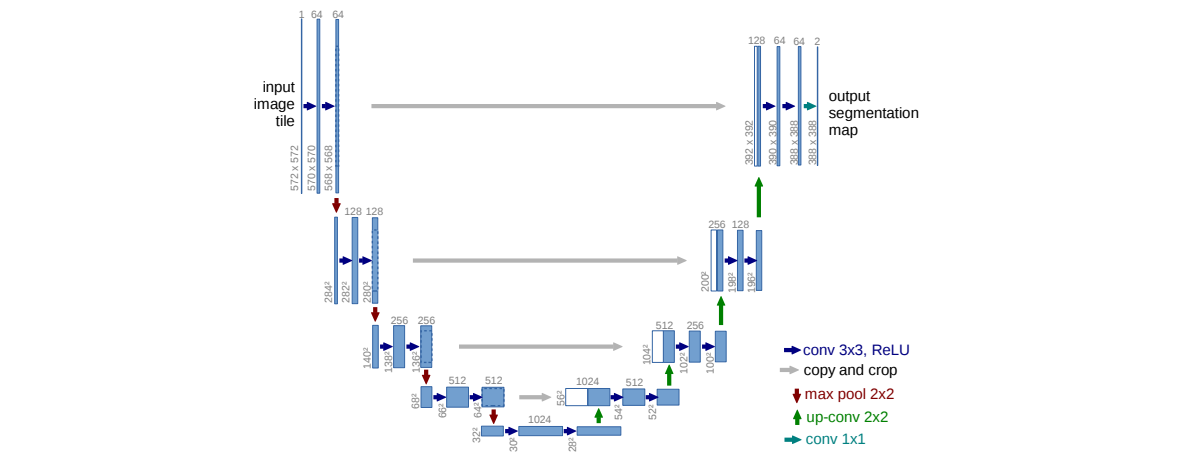

---

## Wichtige Parameter und Erfolgsfaktoren von U-Nets:
**1. Keine Fully Connected Layers:**
- Die U-Net-Architekturen hat im Gegensatz zu einigen anderen tieferen Netzwerkstrukturen keine vollständig verbundenen Schichten (Fully Connected Layers).
    - weniger Paramter --> kleinere Rechenaufwand
    - Lokale Informationen werden besser gelesen



**2. Gewichtete Verlustfunktion (Weighted loss function):**
- Die gewichtete Verlustfunktion gibt bestimmten Fehlern in der Vorhersage mehr Gewicht als anderen.
- Die Idee ist, dass das Model stärker darauft trainiert wied, den Hintergrund zwischen eng verbundenen Objekten genauer zu segmentieren.
- Fehler in diesem Bereich werden stärker bestraft 



**3. Tiling-Strategie:**
- Um grosse Bilder nahtlos zu segmentieren, wird eine Tiling-Strategie verwendet.
- Grosse Bilder werden in kleinere Tiles oder "Kacheln" aufgeteilt und eine Vorhersagen für jede Kachel separat erstellt. 
- Die Kacheln überlappen sich, was bedeutet, dass einige Pixel in einer Kachel auch in benachbarten Kacheln enthalten sind. 



**4. Datenerweiterung mit elastischer Verformung (Data Augmentation):**
- Hier ist das Ziel, die Menge an Trainigsbeispielen zu erhöhen mit elastischer Verformung.
    - räumliche Verzerrungen des Bildes
    - Bild wird gedehnt oder zusammengedrückt, die Form der Objekte im Bild werden jedoch wesentlichen beibehalten.
- Das Model sollte robuster werden



**5. Initialisierung der Gewichte:**
- Die Gewichte im U-Net sollten ungefähr eine Einheistvarianz haben. 
    - Einheitsvarianz bedeutet, dass die Werte in jeder Feature Map in etwa die gleiche Bedeutung oder Wichtigkeit haben sollten.


---

## Quelle

Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation (arXiv:1505.04597). arXiv. http://arxiv.org/abs/1505.04597




In [7]:
pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# importing all the required libraries
import os
import cv2
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Prepare Dataset

In [9]:
#loading training and validation datasets, test dataset doesn't have annotations so we will use split traning data into train and test data
train_label_data_path  = 'cityscapes/gtFine/train'

train_labels = sorted(glob.glob(train_label_data_path+"/*/*_labelIds.png"))

valid_label_data_path  = 'cityscapes/gtFine/val'  
valid_labels = sorted(glob.glob(valid_label_data_path+"/*/*_labelIds.png"))

train_img_path  = 'cityscapes/leftImg8bit/train'
train_inp = sorted(glob.glob(train_img_path+"/*/*.png"))

valid_img_path  = 'cityscapes/leftImg8bit/val'
valid_inp = sorted(glob.glob(valid_img_path+"/*/*.png"))


In [10]:
# #loading training and validation datasets, test dataset doesn't have annotations so we will use split traning data into train and test data
# train_label_data_path  = 'Q:/Projects/u-net-segmentation-of-streets-and-cars/train/cityscapes/gtFine/train'

# train_labels = sorted(glob.glob(train_label_data_path+"/*/*_labelIds.png"))

# valid_label_data_path  = 'Q:/Projects/u-net-segmentation-of-streets-and-cars/train/cityscapes/gtFine/val'  
# valid_labels = sorted(glob.glob(valid_label_data_path+"/*/*_labelIds.png"))

# train_img_path  = 'Q:/Projects/u-net-segmentation-of-streets-and-cars/train/cityscapes/leftImg8bit/train'
# train_inp = sorted(glob.glob(train_img_path+"/*/*.png"))

# valid_img_path  = 'Q:/Projects/u-net-segmentation-of-streets-and-cars/train/cityscapes/leftImg8bit/val'
# valid_inp = sorted(glob.glob(valid_img_path+"/*/*.png"))


In [11]:
from collections import namedtuple

## from labels.py file
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [12]:

  
# labels that will be used has ignoreinEval == False
labels_used = []
ids = []
for i in range(len(labels)):
    # if labels[i].name == 'unlabeled':
    #   labels_used.append(labels[i])
    if(labels[i].ignoreInEval == False):
      labels_used.append(labels[i])
      ids.append(labels[i].id)
print("number of labels used = " + format(len(labels_used )))



#def input_labels(train_labels):
  
label_in = cv2.imread(train_labels[0])[:,:,0]#visualize a sample label

  #return label_in

  
  #create a dictionary with label_id as key & train_id as value
label_dic = {}
for i in range(len(labels)-1):
  label_dic[labels[i].id] = labels[i].trainId


number of labels used = 19


In [13]:
#function to convert labelids to trainids
def createtrainID(label_in ,label_dic):
  mask = np.zeros((label_in.shape[0],label_in.shape[1]))
  l_un = np.unique(label_in)
  for i in range(len(l_un)):
    mask[label_in==l_un[i]] = label_dic[l_un[i]] 
  return mask

In [14]:
#function to visualize the labels
def visual_label(mask,labels_used, plot = False):
  label_img = np.zeros((mask.shape[0],mask.shape[1],3))
  r = np.zeros((mask.shape[0],mask.shape[1]))
  g = np.zeros((mask.shape[0],mask.shape[1]))
  b = np.zeros((mask.shape[0],mask.shape[1]))
  l_un = np.unique(mask)
  for i in range(len(l_un)):
    if l_un[i]<19:
      r[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[0]
      g[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[1]
      b[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[2]
  
  label_img[:,:,0] = r/255
  label_img[:,:,1] = g/255
  label_img[:,:,2] = b/255

  if plot:
    plt.imshow(label_img)
  return label_img

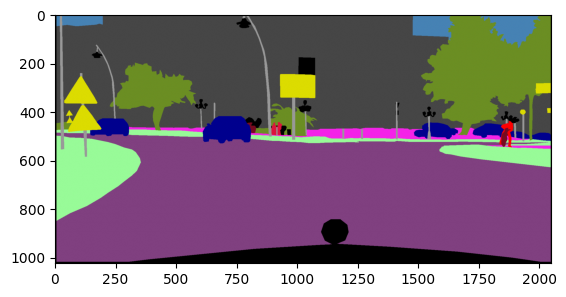

In [15]:
label_img = visual_label(createtrainID(label_in, label_dic), labels_used,plot = True)

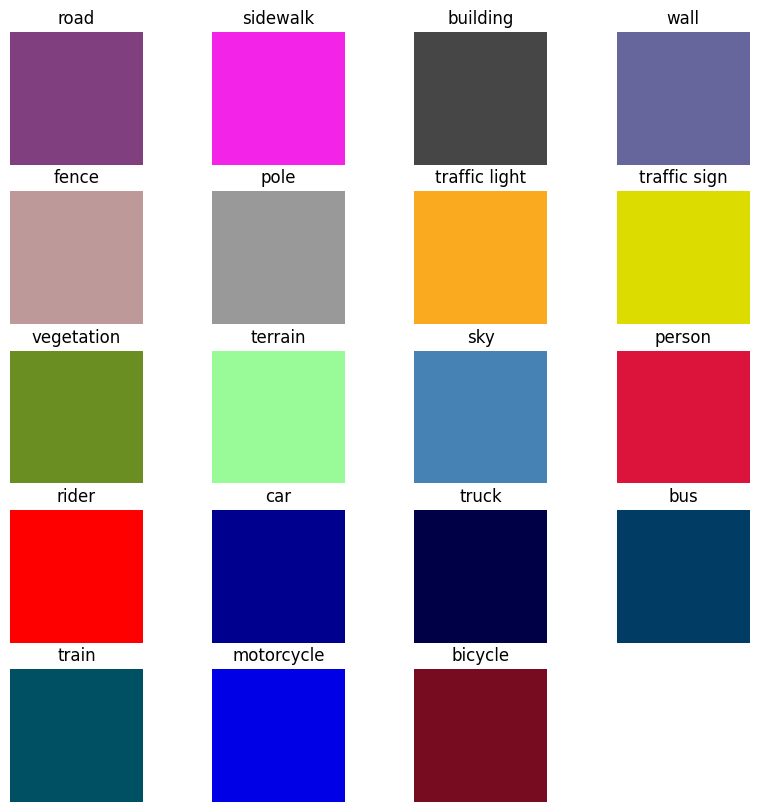

In [16]:
#description of different colors
fig = plt.figure(figsize = (10,10))

for i in range(len(labels_used)):
    temp = np.zeros((5,5,3))
    temp[:,:,0] = labels_used[i].color[0]/255
    temp[:,:,1] = labels_used[i].color[1]/255
    temp[:,:,2] = labels_used[i].color[2]/255
    ax = fig.add_subplot(5, 4, i+1)
    ax.imshow(temp)
    ax.set_title(labels_used[i].name)
    ax.axis('off')

In [17]:
#function to generate images for training, validation and testing
def gen_images(x,s1=96,s2=96):
  _,_,s3 = cv2.imread(x[0]).shape
  img = np.zeros((len(x),s1,s2,s3))
  for i in range(len(x)):
      image= cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)
      image = image/255
      img[i,:,:,:] = image
  return torch.tensor(img).permute(0,3,1,2)



In [18]:
#function to generate images for training, validation and testing
def gen_mask_train(x,label_dic,s1=96,s2=96):
  #s1,s2,_ = cv2.imread(x[0]).shape
  mask = np.zeros((len(x),s1,s2))
  for i in range(len(x)):
      image = createtrainID(cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)[:,:,0],label_dic)
      mask[i,:,:] = image
      mask[mask==255] = 19
  return torch.tensor(mask)

In [19]:
def split_dataset (train_inp, train_labels, valid_inp, valid_labels):

  train = []
  for x in zip(train_inp,train_labels):
    train.append(x)
  valid_dataset =[]
  for x in zip(valid_inp,valid_labels):
    valid_dataset.append(x)

  n =  len(train)
  train_n = int(0.8*n) 
  np.random.seed(0)
  perm = np.random.permutation(n)
  train_dataset = []
  test_dataset = []
  for i in range(len(perm[0:train_n])):   
    train_dataset.append(train[perm[i]])
  for i in range(len(perm[train_n:n])):
    test_dataset.append(train[perm[i]]) 
  
  return train_dataset, valid_dataset, test_dataset

train_dataset, valid_dataset, test_dataset = split_dataset (train_inp, train_labels, valid_inp, valid_labels)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

2380
500
595


In [20]:

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=200, 
                                            shuffle=True, 
                                            num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                            batch_size=200, 
                                            shuffle=True, 
                                            num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size=200, 
                                            shuffle=True, 
                                            num_workers=0)
    


In [21]:
print ("Training set size: {}".format(len(train_dataset)))
print ("Validation set size: {}".format(len(valid_dataset)))
print ("Test set size: {}".format(len(test_dataset)))

Training set size: 2380
Validation set size: 500
Test set size: 595


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
data_iter = iter(train_loader)
x, y = next(data_iter)
img = gen_images(x)
img = img.to(device).type(torch.float)
mask = gen_mask_train(y,label_dic)
mask = mask.to(device)

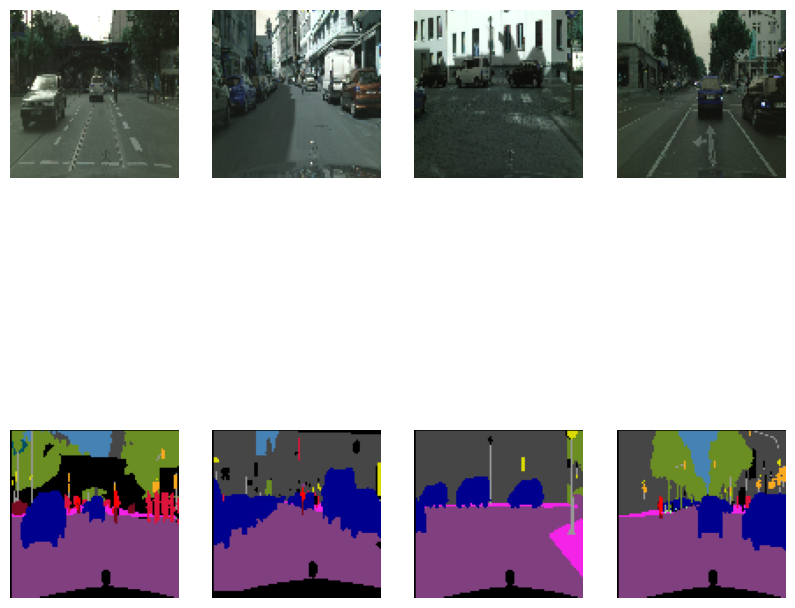

In [24]:
#visualize some of the training images with labels
n_images = 4

fig = plt.figure(figsize = (10,10))

for i in range(n_images*2):
    ax = fig.add_subplot(2, n_images, i+1)
    if i<n_images:
      ax.imshow(img.permute(0,2,3,1)[i,:,:,:].cpu().numpy())
    else:
      ax.imshow(visual_label(mask[int(i%n_images),:,:].cpu().numpy(),labels_used))
    ax.axis('off')

# Model Development (SegNet)

In [25]:
#create different operations of the network opearations of the network
'''
First is the single convolution layer.
convulution->batch_norm->relu
'''
class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)
        self.bn = nn.BatchNorm2d(out_ch,momentum = 0.1)
        self.relu = nn.ReLU()
    def forward(self, x):
        # define forward operation using the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
'''
Second is the maxpool with indicies
'''
class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        self.down = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # use nn.MaxPool2d( )        
    def forward(self, x):
        x1,idx = self.down(x)
        return x1,idx

'''
Third is the unpool layer
'''
class un_pool(nn.Module):
    def __init__(self):
        super(un_pool, self).__init__()       
        self.un_pool = nn.MaxUnpool2d(kernel_size=2, stride=2) # use nn.Upsample() with mode bilinear
        
    
    def forward(self, x, idx,x1):
        #Take the indicies from maxpool layer
        x = self.un_pool(x,idx,output_size = x1.size())
        return x 
'''
Last layer is just convolution layer so we just dust define convoulution
for outlayer
'''
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)

    def forward(self, x):
        # Forward conv layer
        x = self.conv(x)
        return x

In [26]:
# use all above the individual operations to build the network 
class SegNet(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(SegNet, self).__init__()
        self.conv1 = single_conv(n_channels_in,64)
        self.conv2 = single_conv(64,64)
        self.down1 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv3 = single_conv(64,128)
        self.conv4 = single_conv(128,128)
        self.down2 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv5 = single_conv(128,256)
        self.conv6 = single_conv(256,256)
        self.conv7 = single_conv(256,256)
        self.down3 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv8 = single_conv(256,512)
        self.conv9 = single_conv(512,512)
        self.conv10 = single_conv(512,512)
        self.down4 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv11 = single_conv(512,512)
        self.conv12 = single_conv(512,512)
        self.conv13 = single_conv(512,512)
        self.down5 = down_layer()
        self.up1 = un_pool()
        self.conv14 = single_conv(512,512)
        self.conv15 = single_conv(512,512)
        self.conv16 = single_conv(512,512)
        self.up2 = un_pool()
        self.conv17 = single_conv(512,512)
        self.conv18 = single_conv(512,512)
        self.conv19 = single_conv(512,256)
        self.up3 = un_pool()
        self.conv20 = single_conv(256,256)
        self.conv21 = single_conv(256,256)
        self.conv22 = single_conv(256,128)
        self.up4 = un_pool()
        self.conv23 = single_conv(128,128)
        self.conv24 = single_conv(128,64)
        self.up5 = un_pool()
        self.conv25 = single_conv(64,64)
        self.outconv1 = outconv(64,n_classes)

    def forward(self, x):
        # Define forward pass
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3,idx1 = self.down1(x2) # skip connection <-------------------------
        x4 = self.conv3(x3)#                                                |
        x5 = self.conv4(x4)#                                                |
        x6,idx2 = self.down2(x5)# skip connection <-------------------      |
        x7 = self.conv5(x6)#                                         |      |
        x8 = self.conv6(x7)#                                         |      |
        x9 = self.conv7(x8)#                                         |      |
        x10,idx3 = self.down3(x9)# skip connection <-----------      |      |
        x11 = self.conv8(x10)#                                |      |      |
        x12 = self.conv9(x11)#                                |      |      | 
        x13 = self.conv10(x12)#                               |      |      |
        x14,idx4 = self.down4(x13)# skip connection <---      |      |      |
        x15 = self.conv11(x14)#                        |      |      |      |
        x16 = self.conv12(x15)#                        |      |      |      |
        x17 = self.conv13(x16)#                        |      |      |      |
        x18,idx5 = self.down5(x17)#                    |      |      |      |
        x19 = self.up1(x18,idx5,x17)#                  |      |      |      |
        x20 = self.conv14(x19)#                        |      |      |      |
        x21 = self.conv15(x20)#                        |      |      |      |
        x22 = self.conv16(x21)#                        |      |      |      |
        x23 = self.up2(x22,idx4,x13)# skip connection <-      |      |      |
        x24 = self.conv17(x23)#                               |      |      |
        x25 = self.conv18(x24)#                               |      |      |
        x26 = self.conv19(x25)#                               |      |      |
        x27 = self.up3(x26,idx3,x9)# skip connection <---------      |      |
        x28 = self.conv20(x27)#                                      |      |
        x29 = self.conv21(x28)#                                      |      |
        x30 = self.conv22(x29)#                                      |      |
        x31 = self.up4(x30,idx2,x5)# skip connection <----------------      |                                
        x32 = self.conv23(x31)#                                             |
        x33 = self.conv24(x32)#                                             |
        x34 = self.up4(x33,idx1,x2)# skip connection <-----------------------
        x35 = self.conv25(x34)
        x = self.outconv1(x35)
        ## Go up back to original dimension
        return x    

In [27]:
net = SegNet(3,20) #one additional class for pixel ignored

In [28]:
#count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(net))

29454548


In [29]:
NUM_EPOCH = 2 # e.g. 40
BATCH_SIZE = 128 # e.g. 8
LR = 0.001 # e.g. 0.001

In [30]:
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=LR,
)

In [31]:
#initialize the parameters
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)

In [32]:
net.apply(initialize_parameters)

SegNet(
  (conv1): single_conv(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): single_conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down1): down_layer(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): single_conv(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv4): single_conv(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down2): dow

In [33]:
weights = np.zeros((20))
for (_, y) in tqdm(train_loader):
    y = gen_mask_train(y,label_dic)
    y = y.to(device).long()
    for i in range(20):
      weights[i] += torch.sum((y==i).type(torch.uint8))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:34<00:00,  2.86s/it]


In [34]:
weights = np.max(weights)/(weights)
# weights = weights*len(train_dataset)
weights = torch.FloatTensor(weights)

In [35]:
"""using cross entropy loss, but the semantic segmentation suffers from class imbalance so we will use weights for each class in the last update 
for our project"""
net = net.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# Training SegNet on cityscapes dataset

In [36]:
def mean_iou(y_pred,y,num_classes = 20,last_background = True,smooth = 0.001):
  y_pred = torch.argmax(y_pred,dim=1)
  mean_IoU = []
  if last_background:
    num_classes = num_classes - 1
  for i in range(num_classes):
    class_pred = (y_pred==i).type(torch.uint8)
    class_truth = (y==i).type(torch.uint8)
    union = torch.logical_or(class_pred,class_truth).type(torch.uint8)
    intersection = torch.logical_and(class_pred,class_truth).type(torch.uint8)

    """
    There will be problems when denominator of a class is zero. 
    We used the smoothing to counter the problem.
    """
    IoU = torch.sum(intersection+0.001,dim=(1,2))/torch.sum(union+0.001,dim=(1,2))
    # intersection = torch.sum(intersection, dim =(1,2))
    # union = torch.sum(union, dim =(1,2))
    # if torch.sum((union!=0).type(torch.uint8))!=0:
    #   IoU = intersection[union!=0]/union[union!=0]
    mean_IoU.append(IoU.mean())
  mean_IoU = sum(mean_IoU)/num_classes
  return mean_IoU

In [37]:
# define train epoch
def train(model, iterator, optimizer, criterion, device,label_dic):
    
    epoch_loss = 0
    epoch_IoU = 0
    
    model.train()
    
    for (x, y) in tqdm(iterator):
        x = gen_images(x)
        x = x.to(device).type(torch.float)
        y = gen_mask_train(y,label_dic)
        y = y.to(device).long()
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        IoU = mean_iou(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_IoU += IoU.item()
        
    return epoch_loss / len(iterator), epoch_IoU/len(iterator)

In [38]:
def evaluation(model, iterator, criterion, device,label_dic):
    
    epoch_loss = 0
    epoch_IoU = 0
    
    model.eval()
    
    with torch.no_grad():
      for (x, y) in tqdm(iterator):
          x = gen_images(x)
          x = x.to(device).type(torch.float)
          y = gen_mask_train(y,label_dic)
          y = y.to(device).long()
          
          y_pred = model(x)
          
          loss = criterion(y_pred, y)
          
          IoU = mean_iou(y_pred, y)
          
          epoch_loss += loss.item()
          epoch_IoU += IoU.item()
        
    return epoch_loss / len(iterator), epoch_IoU/len(iterator)

In [39]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
train_loss,train_iou = train(net, train_loader, optimizer, criterion, device,label_dic)
valid_loss,valid_iou = evaluation(net, valid_loader, criterion, device,label_dic)

100%|██████████| 3/3 [00:46<00:00, 15.54s/it]


In [41]:
#training for 40 epochs and save the best model 
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(99):
    start_time = time.time()
    
    train_loss,train_iou = train(net, train_loader, optimizer, criterion, device,label_dic)
    valid_loss,valid_iou = evaluation(net, valid_loader, criterion, device,label_dic)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)# ...

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), f'net_epoch{epoch}.pth')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train IoU: {train_iou}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Valid IoU: {valid_iou}')


100%|██████████| 3/3 [00:47<00:00, 15.69s/it]


Epoch: 01 | Epoch Time: 8m 30s
	Train Loss: 1.297 | Train IoU: 0.5521697600682577
	 Val. Loss: 1.899 | Valid IoU: 0.5293182929356893


100%|██████████| 3/3 [00:47<00:00, 15.73s/it]


Epoch: 02 | Epoch Time: 10m 55s
	Train Loss: 1.120 | Train IoU: 0.5851763784885406
	 Val. Loss: 1.332 | Valid IoU: 0.5484546025594076


100%|██████████| 3/3 [00:46<00:00, 15.67s/it]


Epoch: 03 | Epoch Time: 8m 32s
	Train Loss: 1.007 | Train IoU: 0.6022977580626806
	 Val. Loss: 1.238 | Valid IoU: 0.5680495699246725


100%|██████████| 3/3 [00:34<00:00, 11.53s/it]


Epoch: 04 | Epoch Time: 16m 4s
	Train Loss: 0.943 | Train IoU: 0.6138951629400253
	 Val. Loss: 0.986 | Valid IoU: 0.5897504488627116


100%|██████████| 3/3 [00:34<00:00, 11.51s/it]


Epoch: 05 | Epoch Time: 6m 24s
	Train Loss: 0.897 | Train IoU: 0.6220119247833887
	 Val. Loss: 0.930 | Valid IoU: 0.5985401471455892


100%|██████████| 3/3 [00:34<00:00, 11.47s/it]


Epoch: 06 | Epoch Time: 6m 23s
	Train Loss: 0.857 | Train IoU: 0.6292430907487869
	 Val. Loss: 0.905 | Valid IoU: 0.6037785013516744


100%|██████████| 3/3 [00:34<00:00, 11.47s/it]


Epoch: 07 | Epoch Time: 6m 23s
	Train Loss: 0.825 | Train IoU: 0.6352978299061457
	 Val. Loss: 0.911 | Valid IoU: 0.6080764730771383


100%|██████████| 3/3 [00:34<00:00, 11.40s/it]


Epoch: 08 | Epoch Time: 6m 22s
	Train Loss: 0.806 | Train IoU: 0.6379008094469706
	 Val. Loss: 0.943 | Valid IoU: 0.5915125608444214


100%|██████████| 3/3 [00:34<00:00, 11.49s/it]


Epoch: 09 | Epoch Time: 6m 23s
	Train Loss: 0.789 | Train IoU: 0.6375086555878321
	 Val. Loss: 0.878 | Valid IoU: 0.6090574065844218


 58%|█████▊    | 7/12 [03:26<02:27, 29.55s/it]

: 

# Visualize the results on test dataset


In [ ]:
#load the best model
net.load_state_dict(torch.load('net_epoch0.pth'))

<All keys matched successfully>

In [ ]:
test_loss,test_iou = evaluation(net, test_loader, criterion, device,label_dic)
print(f'\tTest Loss: {test_loss:.3f} | Test IoU: {test_iou}')

100%|██████████| 5/5 [15:36<00:00, 187.20s/it]

	Test Loss: 1.310 | Test IoU: 0.5469870448112488


In [ ]:
# print some sample test output and ground
data_iter = iter(test_loader)
x,y = next(data_iter)
img = gen_images(x)
img = img.to(device).type(torch.float)
mask = gen_mask_train(y,label_dic)
mask = mask.to(device)

net.eval()
with torch.no_grad():
  y_pred = net(img)

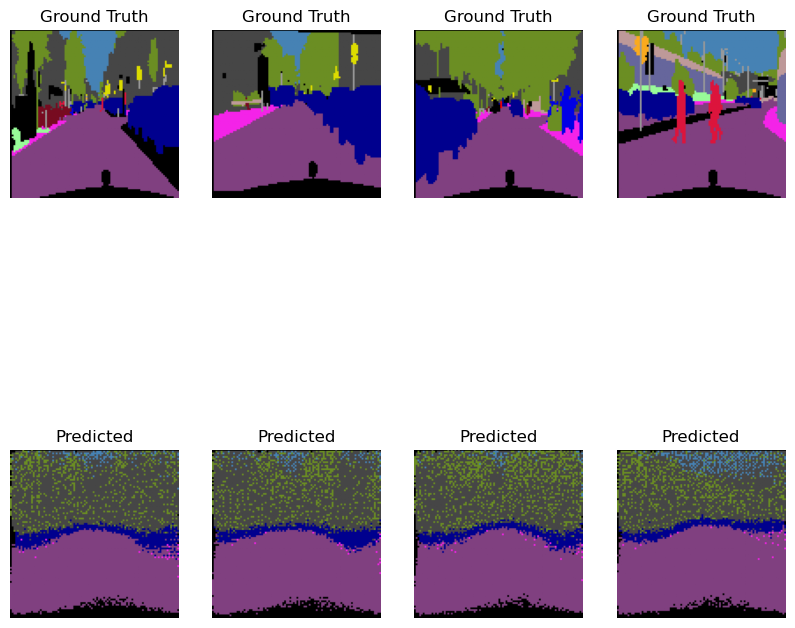

In [ ]:
fig = plt.figure(figsize = (10,10))

for i in range(11,15):
  ax = fig.add_subplot(2, n_images, i-10)
  visualization = visual_label(mask[i,:,:].cpu().numpy(),labels_used)
  ax.imshow(visualization)
  ax.set_title('Ground Truth')
  ax.axis('off')

  ax = fig.add_subplot(2, n_images, i-6)
  y_test = y_pred.permute(0,2,3,1)[i,:,:,:].cpu().numpy()
  visual_test = visual_label(np.argmax(y_test,axis=2),labels_used)
  ax.imshow(visual_test)
  ax.set_title('Predicted')
  ax.axis('off')